<a href="https://colab.research.google.com/github/Adrianosh3/NeuronaleNetze/blob/main/NN_dc_tl_p_00_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 1.10.0+cu111  Device: cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


SETTINGS

In [ ]:
NUM_CLASSES = 2

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0001
Number_Epochs = 5
BATCH_SIZE = 150

In [ ]:
from torchvision.transforms.transforms import RandomHorizontalFlip
####Data augmentation
# Note transforms.ToTensor() scales input images
# to 0-1 range

## train transformations
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
                               ])

## valid transformations
transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.485,0.456,0.406), (0.229,0.224,0.225))
                               ])

In [ ]:
##########################
### Dog and Cat Dataset
##########################

training_dataset = datasets.ImageFolder('/content/drive/MyDrive/Hausarbeit/Data/min/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/Hausarbeit/Data/min/val', transform=transform)


#####################################################
### Data Loaders
#####################################################

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = BATCH_SIZE, shuffle=False)

In [ ]:
# Checking the dataset
print(len(training_dataset))
print(len(validation_dataset))

502
200


In [ ]:
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

for images, labels in validation_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([150, 3, 224, 224])
Image label dimensions: torch.Size([150])
Image batch dimensions: torch.Size([150, 3, 224, 224])
Image label dimensions: torch.Size([150])


Also: batsch size 10, 3 channels, Bilder 224x224

In [ ]:
classes = ('cat', 'dog')

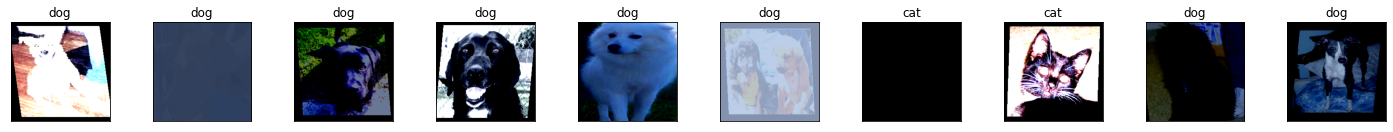

In [ ]:
#### plot 20 training examples

##### convert Tensor to image
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

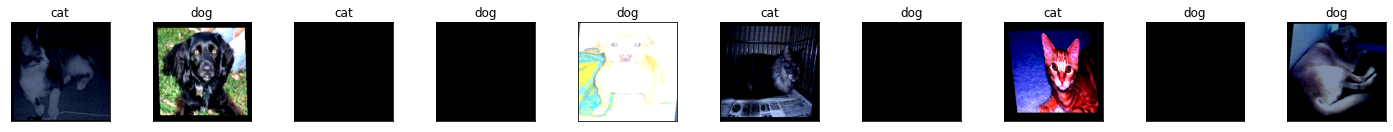

In [ ]:
#### plot 20 validation examples
dataiter_val = iter(validation_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(10):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

LOADING PRETRAINED MODEL

In [ ]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

True: auch weights werden geladen

In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

FREEZING MODEL

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

False: Backpropagation wird also nicht trainiert

REPLACE OUTER LAYER

In [ ]:
model.classifier[6] = nn.Sequential(nn.Linear(4096, NUM_CLASSES))

model_vgg=model.to(device)
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from torchsummary import summary
summary (model_vgg, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
# Loss Function 
criterion = nn.CrossEntropyLoss()
# Opimizer
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
## train function 

def train(epoch, train_loss_list,train_accuracy_list, log_interval=200):
    # Set model to training mode
    model.train()
    train_loss,correct = 0,0

    # Loop over each batch from the training set
    for batch_idx, (X_train, y_train) in enumerate(train_loader):

        # Copy data to GPU if needed
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward Propagation:  compute predicted outputs by passing inputs to the model
        y_predicted = model_vgg(X_train)

        # Zero gradient buffers: clear the gradients of all optimized variables
        optimizer.zero_grad() 

        # Calculate loss
        loss = criterion(y_predicted, y_train)

        # Backpropagate: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # Update weights: perform a single optimization step (parameter update)
        optimizer.step()

      
        # save loss value in train_loss list
        train_loss += loss.item()  
        
        pred = y_predicted.data.max(1)[1]
        correct += (pred == y_train).float().sum()

        # print training statistics 
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(X_train), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
      # calculate average loss over an epoch            
    train_loss /= len(train_loader)
    train_loss_list.append(train_loss)    
    
    accuracy = 100 * correct / len(train_loader.dataset)
    train_accuracy_list.append(accuracy)
    
    print('Train Epoch: {}\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        loss, correct, len(train_loader.dataset), accuracy))

In [ ]:
## Validation function
def validate(val_loss_list,val_accuracy_list):
    model.eval()
    val_loss, correct = 0, 0
    
    for X_val, y_val in validation_loader:

        X_val = X_val.to(device)
        y_val = y_val.to(device)

        # Forward Propagation:  compute predicted outputs by passing inputs to the model
        y_predicted = model_vgg(X_val)
        
        # Calculate loss
        loss = criterion(y_predicted, y_val)
        val_loss += loss.item()  
        
        pred = y_predicted.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(y_val.data).cpu().sum()

    val_loss /= len(validation_loader)
    val_loss_list.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)
    val_accuracy_list.append(accuracy)
    
    print('Val Epoch: {}\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(epoch,
        loss, correct, len(validation_loader.dataset), accuracy))

In [ ]:
######This is now the actual execution of the process
## Train model
##%%time

train_loss_values,val_loss_values, train_acc_values, val_acc_values = [], [], [], []
for epoch in range(Number_Epochs):
    train(epoch,train_loss_values, train_acc_values,)
    validate(val_loss_values, val_acc_values)

Train Epoch: 0 [0/502 (0%)]	Loss: 0.708601
Train Epoch: 0
Train set: Average loss: 0.2693, Accuracy: 383.0/502 (76%)

Val Epoch: 0
Validation set: Average loss: 0.2385, Accuracy: 189/200 (94%)

Train Epoch: 1 [0/502 (0%)]	Loss: 0.246312
Train Epoch: 1
Train set: Average loss: 0.1417, Accuracy: 444.0/502 (88%)

Val Epoch: 1
Validation set: Average loss: 0.0611, Accuracy: 197/200 (98%)

Train Epoch: 2 [0/502 (0%)]	Loss: 0.173155
Train Epoch: 2
Train set: Average loss: 0.2285, Accuracy: 466.0/502 (93%)

Val Epoch: 2
Validation set: Average loss: 0.1517, Accuracy: 194/200 (97%)

Train Epoch: 3 [0/502 (0%)]	Loss: 0.201910
Train Epoch: 3
Train set: Average loss: 0.1845, Accuracy: 466.0/502 (93%)

Val Epoch: 3
Validation set: Average loss: 0.1137, Accuracy: 197/200 (98%)

Train Epoch: 4 [0/502 (0%)]	Loss: 0.098779
Train Epoch: 4
Train set: Average loss: 0.1737, Accuracy: 474.0/502 (94%)

Val Epoch: 4
Validation set: Average loss: 0.0942, Accuracy: 198/200 (99%)



No handles with labels found to put in legend.


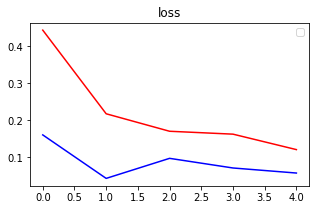

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(Number_Epochs), train_loss_values, 'r')
plt.plot(np.arange(Number_Epochs), val_loss_values, 'b')
plt.title('loss')
plt.legend()

In [ ]:
### copy model to drive
import torch
model_save_name = 'Vgg_cat_dog.pt'
path = F"/content/drive/MyDrive/Hausarbeit/{model_save_name}" 
torch.save(model_vgg.state_dict(), path)

In [ ]:
model_vgg_2 = torch.load(path)

In [ ]:
model_vgg_2

OrderedDict([('features.0.weight',
              tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
                        [-5.8312e-01,  3.5655e-01,  7.6566e-01],
                        [-6.9022e-01, -4.8019e-02,  4.8409e-01]],
              
                       [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
                        [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
                        [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],
              
                       [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
                        [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
                        [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],
              
              
                      [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
                        [-4.2805e-01, -2.4349e-01,  2.4628e-01],
                        [-2.5066e-01,  1.4177e-01, -5.4864e-03]],
              
                       [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
                        [-8.4127e-01, -3